# 01_expt_flip-backprop

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
import bnn as bnn
from bnn import *
import wandb

# Setup

In [ ]:
import fastai
from fastai.tabular.all import *
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from fastai.callback.tensorboard import TensorBoardCallback
from fastai.callback.wandb import WandbCallback

## Prepare Dataset

In [ ]:
# Iris load & make DataFrame
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

cat_names = []
cont_names = iris.feature_names
dep_var = 'target'

In [ ]:
f'num train_df：{len(train_df)}'

'num train_df：120'

## DataLoader

In [ ]:
dls = TabularDataLoaders.from_df(train_df, 
                                 path='.', 
                                 cat_names=cat_names,
                                 cont_names=cont_names, 
                                 y_names=dep_var, 
                                 y_block=CategoryBlock, 
                                 valid_idx=list(valid_df.index),
                                 bs=64,
                                )

In [ ]:
f'num train_ds(dataset) {len(dls.train_ds)}'

'num train_ds(dataset) 90'

batch example

In [ ]:
bx_cat, bx, by = dls.one_batch()
bx_cat, bx, by

(tensor([], size=(64, 0), dtype=torch.int64),
 tensor([[7.0000, 3.2000, 4.7000, 1.4000],
         [7.3000, 2.9000, 6.3000, 1.8000],
         [4.9000, 2.4000, 3.3000, 1.0000],
         [4.3000, 3.0000, 1.1000, 0.1000],
         [6.7000, 3.0000, 5.0000, 1.7000],
         [5.4000, 3.4000, 1.7000, 0.2000],
         [5.1000, 3.5000, 1.4000, 0.3000],
         [4.8000, 3.4000, 1.9000, 0.2000],
         [5.5000, 2.6000, 4.4000, 1.2000],
         [5.3000, 3.7000, 1.5000, 0.2000],
         [6.0000, 2.2000, 5.0000, 1.5000],
         [6.0000, 3.0000, 4.8000, 1.8000],
         [5.7000, 3.0000, 4.2000, 1.2000],
         [6.0000, 2.2000, 4.0000, 1.0000],
         [5.1000, 3.8000, 1.6000, 0.2000],
         [7.2000, 3.2000, 6.0000, 1.8000],
         [5.0000, 3.4000, 1.5000, 0.2000],
         [5.0000, 3.5000, 1.6000, 0.6000],
         [5.6000, 3.0000, 4.1000, 1.3000],
         [4.9000, 3.6000, 1.4000, 0.1000],
         [6.4000, 2.9000, 4.3000, 1.3000],
         [5.7000, 2.6000, 3.5000, 1.0000],
        

# Model

In [ ]:
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.binary_net = self.BinaryNet(hidden_dim, output_dim)

    def forward(self, x_cat, x_cont):
        x = self.fc1(x_cont)
        x = self.relu(x)
        x = self.binary_net(x)
        return x

    class BinaryNet(nn.Module):
        def __init__(self, hidden_features:int=1, out_features:int=1, weights=None, is_standardize=True, pts_sigma=15):
            super().__init__()
            self.binarize = bnn.Binarize(depth_ths=[-1,0,1])
            self.fc2 = bnn.BMA(hidden_features, out_features)
            self.fn = self.BinaryNetFunction.apply

        def forward(self, x):
            x = self.fn(x, self)
            return x 

        class BinaryNetFunction(torch.autograd.Function):
            @staticmethod
            def forward(ctx, x0, model):
                x1 = model.binarize(x0)
                h = model.fc2(x1)
                ctx.save_for_backward(x0,x1)
                ctx.model = model
                return h

            @staticmethod
            def backward(ctx, flip):
                x0,x1 = ctx.saved_tensors
                model = ctx.model
                flip = model.fc2.backward(flip, x1)
                grad = model.binarize.backward(flip, x0)
                return grad, None

input_dim = len(cont_names)
hidden_dim = 64
output_dim = len(iris.target_names)
model = CustomMLP(input_dim, hidden_dim, output_dim)

In [ ]:
model

CustomMLP(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (relu): ReLU()
  (binary_net): BinaryNet(
    (binarize): Binarize()
    (fc2): BMA(
      (weights): BinaryTensor(weights=(3, 8), dtype=uint8)
    )
  )
)

## Model Graph

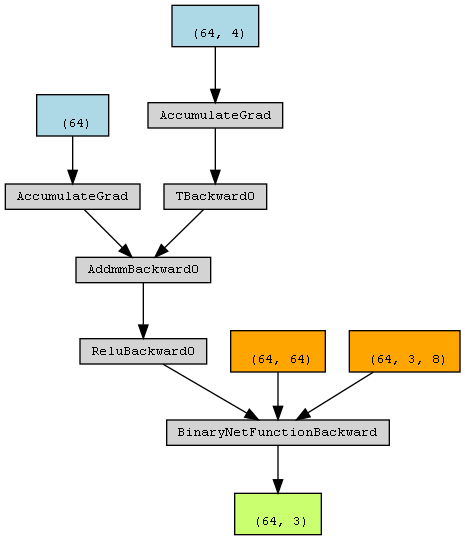

In [ ]:
import torchvision.models as models
from torchviz import make_dot

dot = make_dot(model(bx_cat, bx))
dot.format = 'png'
dot_path = 'outputs/graph_image'
dot.render(dot_path)

from IPython.display import Image
display(Image(filename=dot_path+'.png'))

# Learn

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy,
               cbs=[ShowGraphCallback()])

SuggestedLRs(valley=0.0063095735386013985)

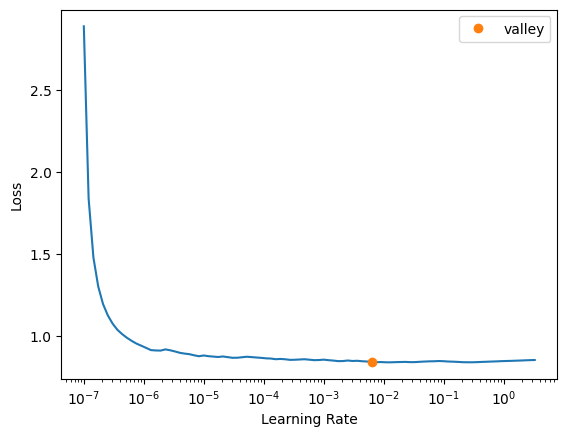

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,3.147014,0.887399,0.466667,00:00
1,2.022781,0.991277,0.633333,00:00
2,1.643010,0.936148,0.666667,00:00
3,1.471122,0.741914,0.766667,00:00
4,1.323188,0.796766,0.666667,00:00
5,1.216040,0.845946,0.666667,00:00
6,1.156968,0.857243,0.666667,00:00
7,1.116694,0.855500,0.666667,00:00
8,1.083254,0.863667,0.666667,00:00
9,1.056560,0.808566,0.666667,00:00


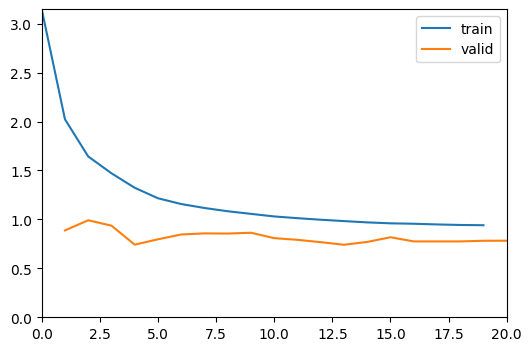

In [ ]:
learn.dls.bs=64
learn.fit_one_cycle(20, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.849276,0.782395,0.666667,00:00
1,0.859008,0.782395,0.666667,00:00
2,0.849793,0.782395,0.666667,00:00
3,0.835788,0.790732,0.666667,00:00
4,0.839042,0.790732,0.666667,00:00
5,0.839535,0.786031,0.666667,00:00
6,0.839186,0.786031,0.666667,00:00
7,0.835327,0.823254,0.666667,00:00
8,0.834927,0.788405,0.700000,00:00
9,0.838408,0.788405,0.700000,00:00


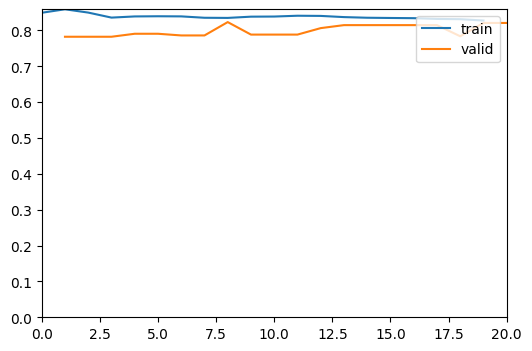

In [ ]:
learn.dls.bs=len(dls.train_ds)
learn.fit_one_cycle(20, lr_max=1e-3)

# Results

In [ ]:
learn.show_results()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_pred
0,5.5,2.4,3.7,1.0,1.0,0.0
1,5.4,3.7,1.5,0.2,0.0,0.0
2,5.8,2.7,4.1,1.0,1.0,2.0
3,5.7,2.9,4.2,1.3,1.0,2.0
4,7.6,3.0,6.6,2.1,2.0,2.0
5,5.8,2.7,5.1,1.9,2.0,2.0
6,4.6,3.6,1.0,0.2,0.0,0.0
7,5.2,4.1,1.5,0.1,0.0,0.0
8,5.2,3.4,1.4,0.2,0.0,0.0


## wandb ver.

wandb: Currently logged in as: lilacs2039. Use `wandb login --relogin` to force relogin


epoch,train_loss,valid_loss,accuracy,time
0,1.645215,0.931080,1.000000,00:00
1,1.297665,0.931080,1.000000,00:00
2,1.167041,0.969888,0.766667,00:00
3,1.118841,0.969888,0.766667,00:00
4,1.089929,0.969888,0.766667,00:00
5,1.071184,0.969888,0.766667,00:00
6,1.056894,0.969888,0.766667,00:00
7,1.046382,0.969888,0.766667,00:00
8,1.038930,0.969888,0.766667,00:00
9,1.032645,0.969888,0.766667,00:00


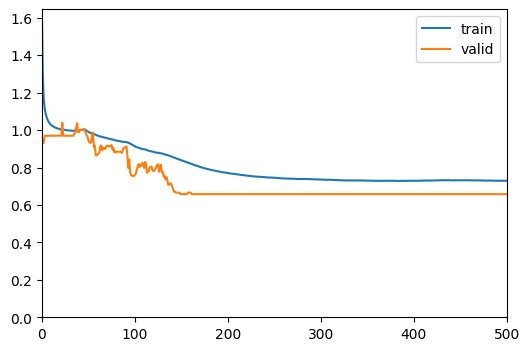

epoch,train_loss,valid_loss,accuracy,time
0,0.745774,0.657727,0.966667,00:00
1,0.740897,0.657727,0.966667,00:00
2,0.728029,0.657727,0.966667,00:00
3,0.720379,0.657727,0.966667,00:00
4,0.722920,0.657727,0.966667,00:00
5,0.724125,0.657727,0.966667,00:00
6,0.723394,0.657727,0.966667,00:00
7,0.723361,0.657727,0.966667,00:00
8,0.725839,0.657727,0.966667,00:00
9,0.724535,0.657727,0.966667,00:00


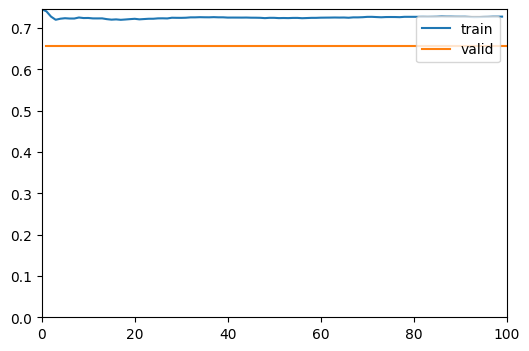

In [ ]:
model = CustomMLP(input_dim, hidden_dim, output_dim)

from fastai.callback.core import Callback
class CustomWandbCallback(WandbCallback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def after_batch(self):
        super().after_batch()
        if self.training:
            self.log_custom_metrics()
    def log_custom_metrics(self):
        self._wandb_step += 1
        custom_metrics = {
            'custom_train_loss': self.learn.loss.item(),
            'custom_lr': self.opt.hypers[-1]['lr'],
            **{f"{name}": wandb.Histogram(param.data.cpu().numpy())
                for name, param in model.named_parameters()},
            **bnn.logger.getLog()
        }
        bnn.logger.clear()
        wandb.log(custom_metrics, step=self._wandb_step)
        
# Learn
wandb.init()  # new Run
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy,
               cbs=[CustomWandbCallback(), ShowGraphCallback()])
learn.dls.bs=64
learn.fit_one_cycle(500, lr_max=1e-2)
learn.dls.bs=len(dls.train_ds)
learn.fit_one_cycle(100, lr_max=1e-3)